# Baseline model
## Introduction
This notebook contains the baseline model that we need to outperform. The baseline model is a weighted average (seasonal) timeseries forecast for the next 4 quarters.

In [ ]:
import polars as pl
import polars.selectors as cs
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sqlalchemy import create_engine  # ← add this line
from pathlib import Path
from config import DIR_DB_SILVER

# --- Database Connection ---
# Check if database exists; handle both root and 'code' directory execution
if not DIR_DB_SILVER.exists():
    if (Path("..") / DIR_DB_SILVER).exists():
        DIR_DB_SILVER = Path("..") / DIR_DB_SILVER
    else:
        raise FileNotFoundError(f"❌ Database not found at {DIR_DB_SILVER}. Ensure you are in the project root.")

# Create a simple SQLAlchemy engine for the Silver database
engine = create_engine(f"sqlite:///{DIR_DB_SILVER}")

# SQL Query to extract and format absenteeism data
query = """
SELECT 
    Perioden as Timeperiod_text,
    printf('%s-%s-01', 
        substr(Perioden, 1, 4), 
        CASE substr(Perioden, 7, 2)
            WHEN '01' THEN '01'
            WHEN '02' THEN '04'
            WHEN '03' THEN '07'
            WHEN '04' THEN '10'
        END
    ) AS Period_startdate, 
    DATE(
        printf('%s-%s-01', 
            substr(Perioden, 1, 4), 
            CASE substr(Perioden, 7, 2)
                WHEN '01' THEN '01'
                WHEN '02' THEN '04'
                WHEN '03' THEN '07'
                WHEN '04' THEN '10'
            END
        ), 
        '+3 months', 
        '-1 day'
    ) AS Period_enddate,
    CAST(Ziekteverzuimpercentage_1 AS REAL) as Absenteeism_perc,
    BedrijfskenmerkenSBI2008_CategoryGroupID as SBI_code
FROM "80072ned_silver"
WHERE Perioden NOT LIKE '%JJ%' 
AND Period_startdate >= '2016-01-01'
"""

# Load into Polars DataFrame
with engine.connect() as conn:
    df_org = pl.read_database(query=query, connection=conn)

print(f"✅ Success! Loaded {len(df_org)} rows.")
df_org.head()

✅ Success! Loaded 1521 rows.


Timeperiod_text,Period_startdate,Period_enddate,Absenteeism_perc,SBI_code
str,str,str,f64,str
"""2024KW03""","""2024-07-01""","""2024-09-30""",5.7,"""5"""
"""2024KW04""","""2024-10-01""","""2024-12-31""",6.3,"""5"""
"""2025KW01""","""2025-01-01""","""2025-03-31""",6.8,"""5"""
"""2025KW02""","""2025-04-01""","""2025-06-30""",6.0,"""5"""
"""2025KW03""","""2025-07-01""","""2025-09-30""",5.9,"""5"""


In [34]:
df_modified = df_org.with_columns(
    # Convert columns ending with 'date' to Date type
    cs.ends_with("date").str.to_date("%Y-%m-%d")
)
df_modified.sort("Period_enddate", descending=True).head()

Timeperiod_text,Period_startdate,Period_enddate,Absenteeism_perc,SBI_code
str,date,date,f64,str
"""2025KW03""",2025-07-01,2025-09-30,5.1,"""1"""
"""2025KW03""",2025-07-01,2025-09-30,3.3,"""2"""
"""2025KW03""",2025-07-01,2025-09-30,5.0,"""3"""
"""2025KW03""",2025-07-01,2025-09-30,5.4,"""2"""
"""2025KW03""",2025-07-01,2025-09-30,5.9,"""3"""


#### Year-on-Year Moving Average Prediction Model
**Goal:** <br> For each quarter (Q1/Q2/Q3/Q4) and SBI_code, calculate a rolling 3-year moving average of Absenteeism_perc as a simple prediction.
Example: The prediction for Q1-2019 = average of Q1-2016, Q1-2017, Q1-2018.

**Step 1: Extract Year and Quarter from Period_startdate** <br>
We derive the quarter (1–4) from the start month of each period. Month 1 = Q1, Month 4 = Q2, Month 7 = Q3, Month 10 = Q4. This allows us to group rows by quarter across different years in the next steps.

In [35]:
df_with_quarter = df_modified.with_columns(
    pl.col("Period_startdate").dt.year().alias("Year"),
    pl.col("Period_startdate").dt.quarter().alias("Quarter")
)
df_with_quarter.head()

Timeperiod_text,Period_startdate,Period_enddate,Absenteeism_perc,SBI_code,Year,Quarter
str,date,date,f64,str,i32,i8
"""2016KW01""",2016-01-01,2016-03-31,4.3,"""1""",2016,1
"""2016KW02""",2016-04-01,2016-06-30,3.8,"""1""",2016,2
"""2016KW03""",2016-07-01,2016-09-30,3.5,"""1""",2016,3
"""2016KW04""",2016-10-01,2016-12-31,4.1,"""1""",2016,4
"""2017KW01""",2017-01-01,2017-03-31,4.3,"""1""",2017,1


**Step 2: Sort the Data** <br>
Polars window functions respect row order, so we must sort by SBI_code, Quarter, and Year to ensure the rolling average looks back over the correct preceding years (e.g. 2016 → 2017 → 2018 for a Q1 prediction of 2019).

In [36]:
df_sorted = df_with_quarter.sort(["SBI_code", "Quarter", "Year"])
df_sorted.head()

Timeperiod_text,Period_startdate,Period_enddate,Absenteeism_perc,SBI_code,Year,Quarter
str,date,date,f64,str,i32,i8
"""2016KW01""",2016-01-01,2016-03-31,4.3,"""1""",2016,1
"""2017KW01""",2017-01-01,2017-03-31,4.3,"""1""",2017,1
"""2018KW01""",2018-01-01,2018-03-31,4.9,"""1""",2018,1
"""2019KW01""",2019-01-01,2019-03-31,4.7,"""1""",2019,1
"""2020KW01""",2020-01-01,2020-03-31,5.2,"""1""",2020,1


**Step 3: Calculate the Rolling 3-Year Moving Average per Quarter and SBI_code** <br>
We use .over(["SBI_code", "Quarter"]) to partition the data into groups, so the rolling average is calculated independently for each unique combination of SBI_code and Quarter (e.g. all Q1 rows for SBI_code "A").

window_size=3 — averages the current row and the 2 preceding rows within that partition (i.e. the 3 most recent years for that quarter)
min_periods=1 — allows the average to be computed even when fewer than 3 years of history are available (e.g. the first year in the data)

In [37]:
df_with_ma = df_sorted.with_columns(
    pl.col("Absenteeism_perc")
    .rolling_mean(window_size=3, min_samples=1)
    .over(["SBI_code", "Quarter"])
    .alias("MA3_Absenteeism_perc")
)
df_with_ma.head()

Timeperiod_text,Period_startdate,Period_enddate,Absenteeism_perc,SBI_code,Year,Quarter,MA3_Absenteeism_perc
str,date,date,f64,str,i32,i8,f64
"""2016KW01""",2016-01-01,2016-03-31,4.3,"""1""",2016,1,4.3
"""2017KW01""",2017-01-01,2017-03-31,4.3,"""1""",2017,1,4.3
"""2018KW01""",2018-01-01,2018-03-31,4.9,"""1""",2018,1,4.5
"""2019KW01""",2019-01-01,2019-03-31,4.7,"""1""",2019,1,4.633333
"""2020KW01""",2020-01-01,2020-03-31,5.2,"""1""",2020,1,4.933333


**Step 4: Shift the Moving Average by 1 to Use it as a Forward Prediction** <br>
The moving average calculated in Step 3 uses the current year's value. To use it as a prediction, we shift it forward by 1 row within each partition — meaning the MA of [2016, 2017, 2018] becomes the prediction for 2019, rather than a description of 2018. Without this shift, the prediction for 2019 would include 2019's own actual value, which would be data leakage.

In [38]:
df_predicted = df_with_ma.with_columns(
    pl.col("MA3_Absenteeism_perc")
    .shift(1)
    .over(["SBI_code", "Quarter"])
    .alias("Predicted_Absenteeism_perc")
)
df_predicted.tail()

Timeperiod_text,Period_startdate,Period_enddate,Absenteeism_perc,SBI_code,Year,Quarter,MA3_Absenteeism_perc,Predicted_Absenteeism_perc
str,date,date,f64,str,i32,i8,f64,f64
"""2023KW04""",2023-10-01,2023-12-31,6.4,"""5""",2023,4,5.166667,4.7
"""2023KW04""",2023-10-01,2023-12-31,4.8,"""5""",2023,4,4.633333,5.166667
"""2024KW04""",2024-10-01,2024-12-31,6.3,"""5""",2024,4,5.833333,4.633333
"""2024KW04""",2024-10-01,2024-12-31,4.7,"""5""",2024,4,5.266667,5.833333
"""2024KW04""",2024-10-01,2024-12-31,2.5,"""5""",2024,4,4.5,5.266667


**Step 1: Prepare the Data for Plotting** <br>
Polars dataframes need to be converted to Pandas for Seaborn to work with them. We also sort by date to ensure the lines are drawn in chronological order.

In [43]:
# Convert to Pandas and sort chronologically for correct line drawing
df_plot = (
    df_predicted
    .select(["Timeperiod_text","Period_enddate", "SBI_code", "Predicted_Absenteeism_perc", "Absenteeism_perc"])
    .drop_nulls()  # Remove the first year per group, which has no prediction due to the shift
    .sort("Period_enddate")
    .to_pandas()
)

**Step 2: Plot the Time Series overall**<br>


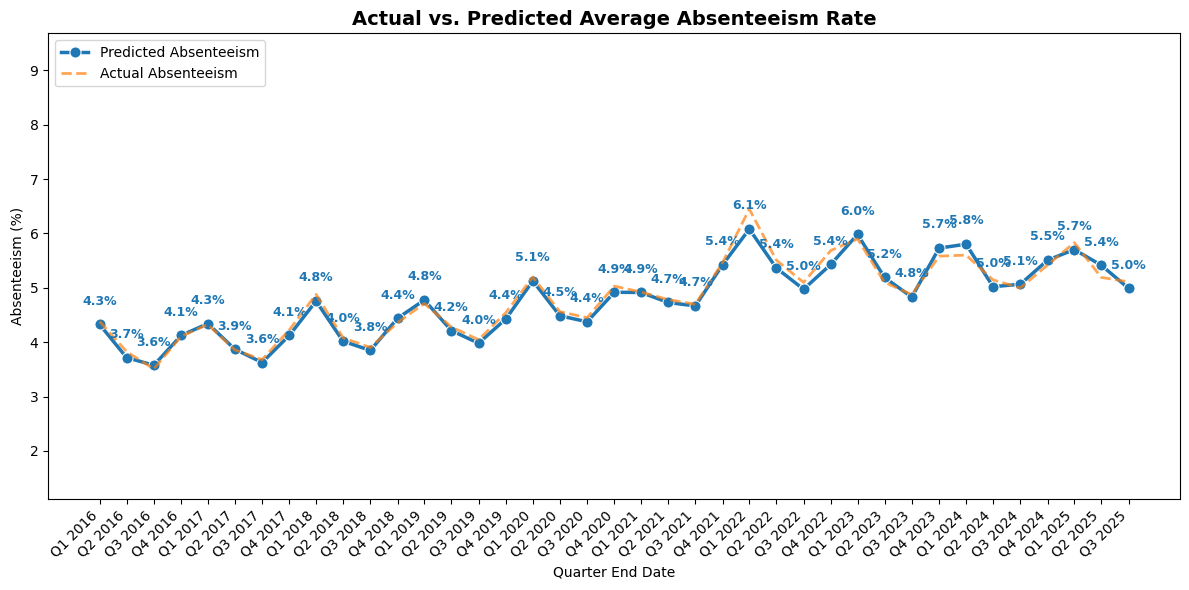

In [ ]:
# 1. Prepare the figure
fig, ax = plt.subplots(figsize=(12, 6))

# 2. Plot Predicted Absenteeism (Primary Line with Markers)
sns.lineplot(
    data=df_plot, 
    x="Period_enddate", 
    y="Predicted_Absenteeism_perc",
    label="Predicted Absenteeism",
    marker="o", 
    errorbar=None,
    ax=ax,
    color="tab:blue",
    linewidth=2.5,
    markersize=8
)

# 3. Plot Actual Absenteeism (Reference Line - No Markers)
sns.lineplot(
    data=df_plot, 
    x="Period_enddate", 
    y="Absenteeism_perc",
    label="Actual Absenteeism",
    marker=None,        # Explicitly remove markers
    errorbar=None,
    ax=ax,
    color="tab:orange",
    linewidth=2,
    linestyle="--",     # Dashed line helps distinguish it as a reference
    alpha=0.7           # Slightly faded to keep focus on predictions
)

# 4. Calculate means and annotate markers ONLY for the Predicted line
df_means = df_plot.groupby("Period_enddate")["Predicted_Absenteeism_perc"].mean().reset_index()

for _, row in df_means.iterrows():
    ax.annotate(
        text=f"{row['Predicted_Absenteeism_perc']:.1f}%",
        xy=(row["Period_enddate"], row["Predicted_Absenteeism_perc"]),
        xytext=(0, 12),
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold",
        color="tab:blue"
    )

# 5. Final Formatting
ax.set_title("Actual vs. Predicted Average Absenteeism Rate", fontsize=14, fontweight="bold")
ax.set_xlabel("Quarter End Date")
ax.set_ylabel("Absenteeism (%)")

# Ensure x-axis ticks match the data points
unique_dates = sorted(df_plot["Period_enddate"].unique())
tick_labels = [f"Q{((d.month - 1) // 3) + 1} {d.year}" for d in unique_dates]

ax.set_xticks(unique_dates)
ax.set_xticklabels(tick_labels, rotation=45, ha="right")

# Adjust limits for headroom
ax.set_ylim(df_plot["Absenteeism_perc"].min() * 0.8, df_plot["Predicted_Absenteeism_perc"].max() * 1.2)

ax.legend(loc="upper left", frameon=True)
plt.tight_layout()
plt.show()

**Step 3: Plot the Time Series per SBI code**<br>
We use sns.lineplot with hue="SBI_code" to draw a separate line per SBI code in a single chart. Each line represents the predicted absenteeism percentage over time for that sector.

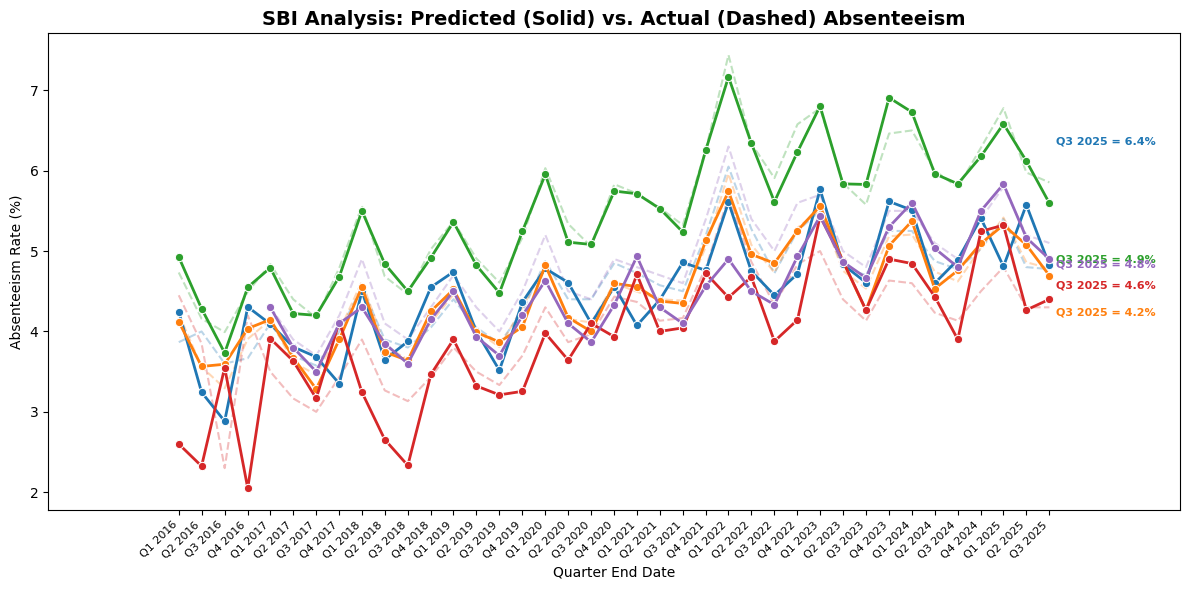

In [53]:
fig, ax = plt.subplots(figsize=(12, 6))

# 1. Plot ACTUALS per SBI (Faded, Dashed, No Markers, No Labels)
# We plot this first so it sits behind the predicted lines
sns.lineplot(
    data=df_plot,
    x="Period_enddate",
    y="Absenteeism_perc",
    hue="SBI_code",
    linestyle="--",
    alpha=0.3,          # Very faded
    linewidth=1.5,
    marker=None,
    errorbar=None,
    legend=False,       # Hide legend for this layer to avoid duplicates
    ax=ax,
    zorder=1
)

# 2. Plot PREDICTED per SBI (Solid, Bold, Markers)
sns.lineplot(
    data=df_plot,
    x="Period_enddate",
    y="Predicted_Absenteeism_perc",
    hue="SBI_code",
    marker="o",
    linewidth=2,
    errorbar=None,
    ax=ax,
    zorder=2
)

# --- Add labels to the last data point of each SBI code line ---
df_last_points = df_plot.groupby("SBI_code").last().reset_index()

quarter_labels = {
    date: f"Q{((date.month - 1) // 3) + 1} {date.year}" 
    for date in df_plot["Period_enddate"].unique()
}

# Get the lines for the predicted data. 
# Since we have two sets of lines (Actuals and Predicted), 
# the second half of ax.get_lines() corresponds to the Predicted lines.
all_lines = ax.get_lines()
predicted_lines = all_lines[len(all_lines)//2:] 

for i, (_, row) in enumerate(df_last_points.iterrows()):
    ax.annotate(
        text=f"{quarter_labels[row['Period_enddate']]} = {row['Predicted_Absenteeism_perc']:.1f}%",
        xy=(row["Period_enddate"], row["Predicted_Absenteeism_perc"]),
        xytext=(5, 0),
        textcoords="offset points",
        va="center",
        fontsize=8,
        fontweight="bold",
        color=predicted_lines[i].get_color() # Match color to the specific SBI line
    )

# --- Labels and formatting ---
ax.set_title("SBI Analysis: Predicted (Solid) vs. Actual (Dashed) Absenteeism", fontsize=14, fontweight="bold")
ax.set_xlabel("Quarter End Date")
ax.set_ylabel("Absenteeism Rate (%)")
ax.set_xticks(list(quarter_labels.keys()))
ax.set_xticklabels(list(quarter_labels.values()), rotation=45, ha="right", fontsize=8)

ax.margins(x=0.15)
ax.legend().remove()

plt.tight_layout()
plt.show()